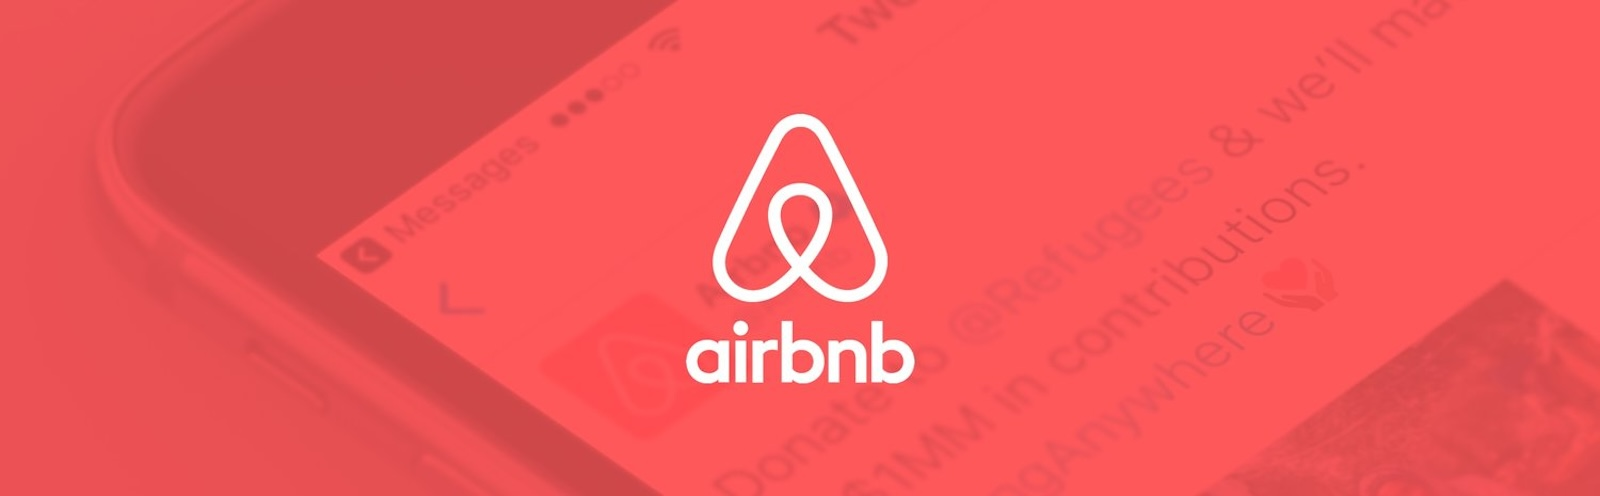!

## 1. Problem Definition
- **Objective**: Identify trends in Airbnb listings operated by inferred professional hosts (defined as hosts with 5+ listings) and estimate their market share across six cities for an international real estate firm.
- **Scope**: Analyze listings data to compare professional and individual hosts based on price, room type, minimum stay requirements, and other metrics, and produce a report accessible to a broad audience.
- **Key Metrics**:
  - Percentage of listings operated by professional hosts.
  - Differences in pricing, availability, reviews, and room type preferences between professional and individual hosts.
  - Geographic and neighborhood-level price distributions.
- **Stakeholders**: International real estate firm, lead consultant, and broader audience (non-technical stakeholders).


In [1]:
# Import all required libraries for comprehensive data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium import plugins
import requests
import warnings
from datetime import datetime
import os

# Set up visualization parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Create output directory for saving files
os.makedirs('/home/user/output', exist_ok=True)

print("✅ All required libraries imported successfully")

✅ All required libraries imported successfully


## 2. Data Collection
- **Source**: InsideAirbnb dataset with six CSV files, each containing listings data for a city (Austin, Bangkok, Buenos Aires, Cape Town, Istanbul, Melbourne).
- **Data Description**: Each row represents a listing with attributes like `id`, `host_id`, `price`, `room_type`, `minimum_nights`, `calculated_host_listings_count`, `latitude`, `longitude`, `neighbourhood`, etc.
- **Method**: Data loaded from local CSV files using a custom `load_dataset` function in Python, with city identifiers added to each dataset.

In [2]:
# Function to load datasets from local directory
def load_dataset(city, file_path):
    """Load a dataset from a local CSV file with city identifier"""
    try:
        print(f"🔄 Loading {city} dataset...")
        df = pd.read_csv(file_path)
        df['city'] = city  # Add city identifier
        print(f"✅ {city}: {len(df):,} listings loaded")
        return df
    except Exception as e:
        print(f"❌ Error loading {city}: {str(e)}")
        return None

# Dictionary mapping city names to their respective CSV file paths
datasets = {
    'Austin': 'listings_austin.csv',
    'Bangkok': 'listings_bangkok.csv',
    'Buenos Aires': 'listings_buenos_aires.csv',
    'Cape Town': 'listings_cape_town.csv',
    'Istanbul': 'listings_istanbul.csv',
    'Melbourne': 'listings_melbourne.csv'
}

# Load all datasets
dataframes = {}
for city, file_path in datasets.items():
    df = load_dataset(city, file_path)
    if df is not None:
        dataframes[city] = df

🔄 Loading Austin dataset...
✅ Austin: 11,269 listings loaded
🔄 Loading Bangkok dataset...
✅ Bangkok: 17,431 listings loaded
🔄 Loading Buenos Aires dataset...
✅ Buenos Aires: 17,671 listings loaded
🔄 Loading Cape Town dataset...
✅ Cape Town: 16,891 listings loaded
🔄 Loading Istanbul dataset...
✅ Istanbul: 22,539 listings loaded
🔄 Loading Melbourne dataset...
✅ Melbourne: 18,016 listings loaded


In [3]:
# Combine all datasets into a single DataFrame
combined_df = pd.concat(dataframes.values(), ignore_index=True)

print("🎯 DATASET LOADING SUMMARY")
print("=" * 50)
print(f"Total cities loaded: {len(dataframes)}")
print(f"Combined dataset shape: {combined_df.shape}")
print(f"Total listings across all cities: {len(combined_df):,}")

# Show breakdown by city
print("\n📊 LISTINGS BY CITY:")
city_counts = combined_df['city'].value_counts()
for city, count in city_counts.items():
    percentage = (count / len(combined_df)) * 100
    print(f"  • {city:<12}: {count:>6,} listings ({percentage:>5.1f}%)")
    
print("\n✅ All datasets successfully loaded and combined!")

🎯 DATASET LOADING SUMMARY
Total cities loaded: 6
Combined dataset shape: (103817, 19)
Total listings across all cities: 103,817

📊 LISTINGS BY CITY:
  • Istanbul    : 22,539 listings ( 21.7%)
  • Melbourne   : 18,016 listings ( 17.4%)
  • Buenos Aires: 17,671 listings ( 17.0%)
  • Bangkok     : 17,431 listings ( 16.8%)
  • Cape Town   : 16,891 listings ( 16.3%)
  • Austin      : 11,269 listings ( 10.9%)

✅ All datasets successfully loaded and combined!


In [4]:
# Examine the data structure and identify data quality issues
print("🔍 DATA STRUCTURE ANALYSIS")
print("=" * 50)
print(f"Dataset shape: {combined_df.shape}")
print(f"Columns: {list(combined_df.columns)}")

print("\n📊 DATA TYPES:")
print(combined_df.dtypes)

print("\n🔍 FIRST FEW ROWS:")
display(combined_df.head())

🔍 DATA STRUCTURE ANALYSIS
Dataset shape: (103817, 19)
Columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license', 'city']

📊 DATA TYPES:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count     

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,city
0,2265,Zen-East in the Heart of Austin (monthly rental),2466,Paddy,NaN,78702,30.27752,-97.71377,Entire home/apt,179,7,26,2021-07-02,0.36,3,35,2,NaN,Austin
1,5245,"Eco friendly, Colorful, Clean, Cozy monthly share",2466,Paddy,NaN,78702,30.27614,-97.71320,Private room,114,30,9,2017-02-24,0.21,3,0,0,NaN,Austin
2,5456,"Walk to 6th, Rainey St and Convention Ctr",8028,Sylvia,NaN,78702,30.26057,-97.73441,Entire home/apt,108,2,575,2021-09-25,24.16,1,324,39,NaN,Austin
3,5769,NW Austin Room,8186,Elizabeth,NaN,78729,30.45697,-97.78422,Private room,39,1,264,2021-07-03,5.95,1,0,7,NaN,Austin
4,6413,Gem of a Studio near Downtown,13879,Todd,NaN,78704,30.24885,-97.73587,Entire home/apt,109,3,117,2021-04-02,1.27,1,0,4,NaN,Austin


In [5]:
# Analyze missing values and data quality issues
print("🔍 MISSING VALUES ANALYSIS")
print("=" * 50)
missing_info = combined_df.isnull().sum()
missing_pct = (missing_info / len(combined_df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_info,
    'Missing %': missing_pct
}).sort_values('Missing %', ascending=False)

# Only show columns with missing values
missing_cols = missing_df[missing_df['Missing Count'] > 0]
if len(missing_cols) > 0:
    print("Columns with missing values:")
    for col, row in missing_cols.iterrows():
        print(f"  • {col:<25}: {row['Missing Count']:>7,} ({row['Missing %']:>6.2f}%)")
else:
    print("✅ No missing values found!")

print(f"\nℹ️  Total records: {len(combined_df):,}")

🔍 MISSING VALUES ANALYSIS
Columns with missing values:
  • neighbourhood_group      : 103,817.0 (100.00%)
  • license                  : 103,713.0 ( 99.90%)
  • last_review              : 34,883.0 ( 33.60%)
  • reviews_per_month        : 34,883.0 ( 33.60%)
  • host_name                :    72.0 (  0.07%)
  • name                     :    41.0 (  0.04%)

ℹ️  Total records: 103,817


## 3. Data Preparation
- **Cleaning**:
  - Handled missing values:
    - `neighbourhood_group` (100% missing): Ignored due to irrelevance.
    - `license` (99.9% missing): Created a binary `has_license` indicator.
    - `last_review` and `reviews_per_month` (33.6% missing): Filled `reviews_per_month` with 0, converted `last_review` to datetime.
    - `host_name` and `name` (<0.1% missing): Filled with 'Unknown Host' and 'Untitled Listing'.
  - Removed extreme price outliers (top 1% and zero prices), retaining 99% of records.

In [6]:
# Perform data cleaning and preprocessing
print("🧹 DATA CLEANING AND PREPROCESSING")
print("=" * 50)

# Create a copy for cleaning
df_clean = combined_df.copy()

# 1. Handle date columns
print("📅 Converting date columns...")
df_clean['last_review'] = pd.to_datetime(df_clean['last_review'], errors='coerce')

# 2. Fill missing reviews_per_month with 0 (no reviews)
print("📊 Handling missing review data...")
df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(0)

# 3. Handle missing host names
print("👤 Handling missing host names...")
df_clean['host_name'] = df_clean['host_name'].fillna('Unknown Host')

# 4. Handle missing listing names
print("📝 Handling missing listing names...")
df_clean['name'] = df_clean['name'].fillna('Untitled Listing')

# 5. Create binary indicators for missing data
df_clean['has_reviews'] = df_clean['number_of_reviews'] > 0
df_clean['has_license'] = df_clean['license'].notna()

# 6. Remove extreme outliers in price (top 1% and price = 0)
print("💰 Handling price outliers...")
price_q99 = df_clean['price'].quantile(0.99)
df_clean_filtered = df_clean[(df_clean['price'] > 0) & (df_clean['price'] <= price_q99)].copy()

print(f"  • Removed {len(df_clean) - len(df_clean_filtered):,} extreme price outliers")
print(f"  • Price range after cleaning: ${df_clean_filtered['price'].min():.0f} - ${df_clean_filtered['price'].max():.0f}")

# 7. Create categorical variables
print("🏷️  Creating categorical variables...")
df_clean_filtered['price_category'] = pd.cut(df_clean_filtered['price'], 
                                           bins=[0, 50, 100, 200, 500, float('inf')],
                                           labels=['Budget (<$50)', 'Moderate ($50-100)', 
                                                  'Premium ($100-200)', 'Luxury ($200-500)',
                                                  'Ultra-luxury ($500+)'])

# 8. Create minimum nights categories
df_clean_filtered['stay_type'] = df_clean_filtered['minimum_nights'].apply(
    lambda x: 'Short-term (1-6 nights)' if x <= 6 
    else 'Medium-term (7-29 nights)' if x <= 29
    else 'Long-term (30+ nights)'
)

print(f"\n✅ Data cleaning completed!")
print(f"Final dataset shape: {df_clean_filtered.shape}")
print(f"Records retained: {len(df_clean_filtered):,} ({(len(df_clean_filtered)/len(combined_df)*100):.1f}%)")

# Update our working dataset
df = df_clean_filtered.copy()

🧹 DATA CLEANING AND PREPROCESSING
📅 Converting date columns...
📊 Handling missing review data...
👤 Handling missing host names...
📝 Handling missing listing names...
💰 Handling price outliers...
  • Removed 1,050 extreme price outliers
  • Price range after cleaning: $1 - $15432
🏷️  Creating categorical variables...

✅ Data cleaning completed!
Final dataset shape: (102767, 23)
Records retained: 102,767 (99.0%)


## 4. Exploratory Data Analysis (EDA)


In [7]:
# Comprehensive exploratory data analysis
print("📊 EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# Basic statistics
print("🔢 BASIC STATISTICS:")
print(f"  • Total listings: {len(df):,}")
print(f"  • Cities covered: {df['city'].nunique()}")
print(f"  • Unique hosts: {df['host_id'].nunique():,}")
print(f"  • Date range: {df['last_review'].min().strftime('%Y-%m-%d') if df['last_review'].notna().any() else 'N/A'} to {df['last_review'].max().strftime('%Y-%m-%d') if df['last_review'].notna().any() else 'N/A'}")

print("\n💰 PRICE STATISTICS BY CITY:")
price_stats = df.groupby('city')['price'].agg(['count', 'mean', 'median', 'min', 'max']).round(2)
display(price_stats)

print("\n🏠 ROOM TYPE DISTRIBUTION:")
room_type_dist = df['room_type'].value_counts()
for room_type, count in room_type_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  • {room_type:<18}: {count:>6,} ({percentage:>5.1f}%)")

print("\n🗂️  PRICE CATEGORY DISTRIBUTION:")
price_cat_dist = df['price_category'].value_counts()
for category, count in price_cat_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  • {category:<22}: {count:>6,} ({percentage:>5.1f}%)")

print("\n🏨 STAY TYPE DISTRIBUTION:")
stay_type_dist = df['stay_type'].value_counts()
for stay_type, count in stay_type_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  • {stay_type:<25}: {count:>6,} ({percentage:>5.1f}%)")

📊 EXPLORATORY DATA ANALYSIS
🔢 BASIC STATISTICS:
  • Total listings: 102,767
  • Cities covered: 6
  • Unique hosts: 58,930
  • Date range: 2010-06-14 to 2021-11-07

💰 PRICE STATISTICS BY CITY:


,count,mean,median,min,max
city,,,,,
Austin,11267,293.59,164.0,1,12980
Bangkok,17235,1649.97,1099.0,13,15432
Buenos Aires,17125,3750.58,2981.0,174,15420
Cape Town,16636,1895.73,1100.0,120,15388
Istanbul,22489,673.49,437.0,38,15379
Melbourne,18015,173.15,110.0,13,15000



🏠 ROOM TYPE DISTRIBUTION:
  • Entire home/apt   : 68,579 ( 66.7%)
  • Private room      : 30,119 ( 29.3%)
  • Hotel room        :  2,086 (  2.0%)
  • Shared room       :  1,983 (  1.9%)

🗂️  PRICE CATEGORY DISTRIBUTION:
  • Ultra-luxury ($500+)  : 58,021 ( 56.5%)
  • Luxury ($200-500)     : 19,162 ( 18.6%)
  • Premium ($100-200)    : 13,329 ( 13.0%)
  • Moderate ($50-100)    :  8,708 (  8.5%)
  • Budget (<$50)         :  3,547 (  3.5%)

🏨 STAY TYPE DISTRIBUTION:
  • Short-term (1-6 nights)  : 85,783 ( 83.5%)
  • Medium-term (7-29 nights): 10,718 ( 10.4%)
  • Long-term (30+ nights)   :  6,266 (  6.1%)


In [8]:
# Analyze host listings count distribution
print("🏠 HOST LISTINGS COUNT ANALYSIS")
print("=" * 50)

host_listings_stats = df['calculated_host_listings_count'].describe()
print("Basic statistics for calculated_host_listings_count:")
print(host_listings_stats)

print(f"\n📊 DISTRIBUTION OF HOST LISTINGS COUNT:")
# Create bins for host listings count
host_bins = [1, 2, 3, 5, 10, 25, 50, float('inf')]
host_labels = ['1 listing', '2 listings', '3-4 listings', '5-9 listings', 
               '10-24 listings', '25-49 listings', '50+ listings']

df['host_category'] = pd.cut(df['calculated_host_listings_count'], 
                            bins=host_bins, labels=host_labels, right=False)

host_dist = df['host_category'].value_counts().sort_index()
for category, count in host_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  • {category:<15}: {count:>6,} ({percentage:>5.1f}%)")

# Professional host definition based on distribution
print(f"\n🎯 PROFESSIONAL HOST CRITERIA:")
# Define professional hosts as those with 5+ listings (common industry threshold)
print("  • Professional hosts defined as: 5+ listings")
professional_threshold = 5
df['is_professional_host'] = df['calculated_host_listings_count'] >= professional_threshold

professional_count = df['is_professional_host'].sum()
professional_pct = (professional_count / len(df)) * 100

print(f"  • Professional host listings: {professional_count:,} ({professional_pct:.1f}%)")
print(f"  • Individual host listings: {len(df) - professional_count:,} ({100 - professional_pct:.1f}%)")

🏠 HOST LISTINGS COUNT ANALYSIS
Basic statistics for calculated_host_listings_count:
count    102767.000000
mean          9.092471
std          24.196740
min           1.000000
25%           1.000000
50%           2.000000
75%           6.000000
max         293.000000
Name: calculated_host_listings_count, dtype: float64

📊 DISTRIBUTION OF HOST LISTINGS COUNT:
  • 1 listing      : 45,730 ( 44.5%)
  • 2 listings     : 13,184 ( 12.8%)
  • 3-4 listings   : 12,162 ( 11.8%)
  • 5-9 listings   : 12,405 ( 12.1%)
  • 10-24 listings : 10,458 ( 10.2%)
  • 25-49 listings :  4,700 (  4.6%)
  • 50+ listings   :  4,128 (  4.0%)

🎯 PROFESSIONAL HOST CRITERIA:
  • Professional hosts defined as: 5+ listings
  • Professional host listings: 31,691 (30.8%)
  • Individual host listings: 71,076 (69.2%)


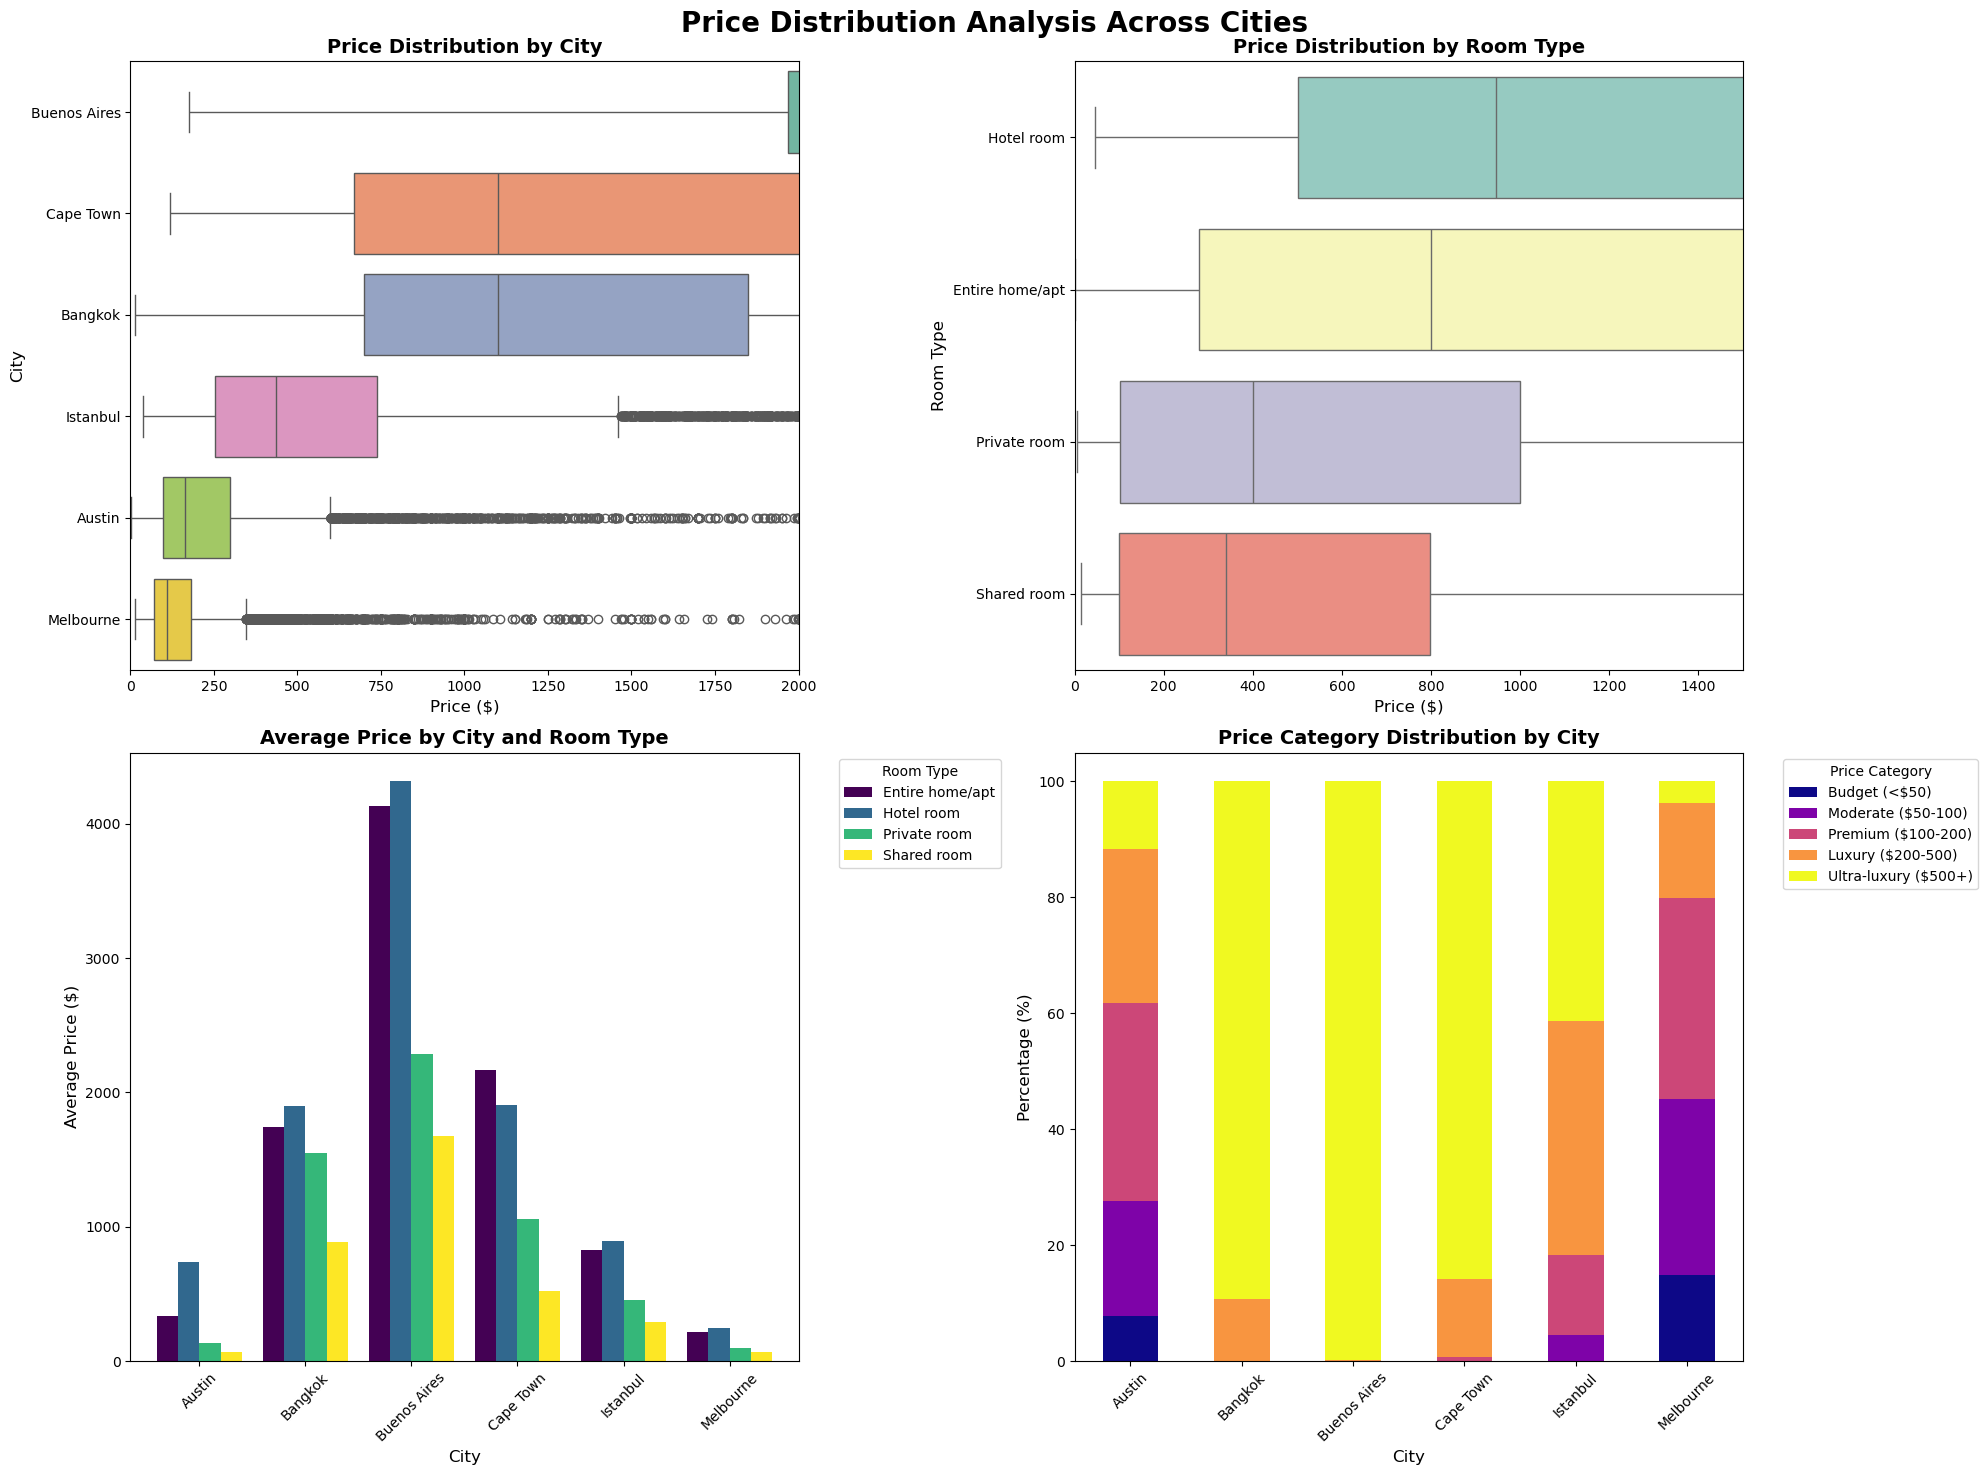

💰 Price Distribution Analysis Complete!


In [9]:
# Create comprehensive price distribution visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Price Distribution Analysis Across Cities', fontsize=20, fontweight='bold')

# 1. Price by City (Box plot)
ax1 = axes[0, 0]
city_order = df.groupby('city')['price'].median().sort_values(ascending=False).index
sns.boxplot(data=df, y='city', x='price', order=city_order, ax=ax1, palette='Set2')
ax1.set_xlabel('Price ($)', fontsize=12)
ax1.set_ylabel('City', fontsize=12)
ax1.set_title('Price Distribution by City', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 2000)  # Focus on main price range

# 2. Price by Room Type
ax2 = axes[0, 1]
room_order = df.groupby('room_type')['price'].median().sort_values(ascending=False).index
sns.boxplot(data=df, y='room_type', x='price', order=room_order, ax=ax2, palette='Set3')
ax2.set_xlabel('Price ($)', fontsize=12)
ax2.set_ylabel('Room Type', fontsize=12)
ax2.set_title('Price Distribution by Room Type', fontsize=14, fontweight='bold')
ax2.set_xlim(0, 1500)

# 3. Average Price by City and Room Type
ax3 = axes[1, 0]
price_pivot = df.groupby(['city', 'room_type'])['price'].mean().unstack()
price_pivot.plot(kind='bar', ax=ax3, colormap='viridis', width=0.8)
ax3.set_xlabel('City', fontsize=12)
ax3.set_ylabel('Average Price ($)', fontsize=12)
ax3.set_title('Average Price by City and Room Type', fontsize=14, fontweight='bold')
ax3.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.tick_params(axis='x', rotation=45)

# 4. Price Category Distribution by City
ax4 = axes[1, 1]
price_cat_pivot = pd.crosstab(df['city'], df['price_category'], normalize='index') * 100
price_cat_pivot.plot(kind='bar', stacked=True, ax=ax4, colormap='plasma')
ax4.set_xlabel('City', fontsize=12)
ax4.set_ylabel('Percentage (%)', fontsize=12)
ax4.set_title('Price Category Distribution by City', fontsize=14, fontweight='bold')
ax4.legend(title='Price Category', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("💰 Price Distribution Analysis Complete!")


In [10]:
# Create detailed neighborhood analysis for each city 
print("🏘️  NEIGHBORHOOD PRICE ANALYSIS")
print("=" * 50)

# Analyze top neighborhoods by average price for each city
for city in df['city'].unique():
    city_data = df[df['city'] == city]
    
    # Get neighborhood statistics
    neighborhood_stats = city_data.groupby('neighbourhood').agg({
        'price': ['count', 'mean', 'median']
    }).round(2)
    
    # Flatten column names
    neighborhood_stats.columns = ['listing_count', 'price_mean', 'price_median']
    
    # Filter neighborhoods with at least 10 listings
    neighborhood_stats = neighborhood_stats[neighborhood_stats['listing_count'] >= 10]
    
    # Sort by average price
    top_neighborhoods = neighborhood_stats.sort_values('price_mean', ascending=False).head(10)
    
    print(f"\n🏙️  {city.upper()} - Top 10 Most Expensive Neighborhoods:")
    print(f"{'Neighborhood':<25} {'Listings':<10} {'Avg Price':<12} {'Median Price'}")
    print("-" * 65)
    
    for neighborhood, row in top_neighborhoods.iterrows():
        neighborhood_short = str(neighborhood)[:24]
        print(f"{neighborhood_short:<25} {int(row['listing_count']):<10} "
              f"${row['price_mean']:<11.0f} ${row['price_median']:<11.0f}")
        
# Create summary statistics table
city_neighborhood_summary = []
for city in df['city'].unique():
    city_data = df[df['city'] == city]
    neighborhoods = city_data['neighbourhood'].nunique()
    avg_price = city_data['price'].mean()
    median_price = city_data['price'].median()
    
    city_neighborhood_summary.append({
        'City': city,
        'Neighborhoods': neighborhoods,
        'Avg_Price': avg_price,
        'Median_Price': median_price
    })

summary_df = pd.DataFrame(city_neighborhood_summary)
print(f"\n📊 CITY SUMMARY:")
display(summary_df.round(2))

🏘️  NEIGHBORHOOD PRICE ANALYSIS

🏙️  AUSTIN - Top 10 Most Expensive Neighborhoods:
Neighborhood              Listings   Avg Price    Median Price
-----------------------------------------------------------------
78733                     77         $810         $259        
78730                     41         $808         $250        
78732                     62         $775         $392        
78746                     266        $619         $290        
78737                     126        $451         $196        
78703                     523        $413         $200        
78734                     250        $390         $259        
78739                     26         $367         $243        
78701                     747        $349         $260        
78750                     46         $341         $114        

🏙️  BANGKOK - Top 10 Most Expensive Neighborhoods:
Neighborhood              Listings   Avg Price    Median Price
-------------------------------------------

,City,Neighborhoods,Avg_Price,Median_Price
0,Austin,44,293.59,164.0
1,Bangkok,50,1649.97,1099.0
2,Buenos Aires,48,3750.58,2981.0
3,Cape Town,89,1895.73,1100.0
4,Istanbul,39,673.49,437.0
5,Melbourne,30,173.15,110.0


In [11]:
# Create geographical visualizations for each city
print("🗺️  CREATING GEOGRAPHICAL VISUALIZATIONS")
print("=" * 50)

# City coordinates for map centering
city_coords = {
    'Melbourne': [-37.8136, 144.9631],
    'Bangkok': [13.7563, 100.5018],
    'Austin': [30.2672, -97.7431],
    'Istanbul': [41.0082, 28.9784],
    'Cape Town': [-33.9249, 18.4241],
    'Buenos Aires': [-34.6037, -58.3816]
}

# Create individual maps for each city
for city_name, coords in city_coords.items():
    city_data = df[df['city'] == city_name].copy()
    
    # Sample data if too large (for performance)
    if len(city_data) > 5000:
        city_data = city_data.sample(n=5000, random_state=42)
    
    print(f"📍 Creating map for {city_name} ({len(city_data):,} listings)...")
    
    # Create base map
    m = folium.Map(location=coords, zoom_start=11, tiles='OpenStreetMap')
    
    # Define color scale based on price quantiles
    price_quantiles = city_data['price'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    def get_color(price):
        if price <= price_quantiles[0.2]:
            return 'green'
        elif price <= price_quantiles[0.4]:
            return 'yellow'
        elif price <= price_quantiles[0.6]:
            return 'orange'
        elif price <= price_quantiles[0.8]:
            return 'red'
        else:
            return 'darkred'
    
    # Add markers for listings
    for idx, row in city_data.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            popup=f"<b>{row['name'][:30]}...</b><br>"
                  f"Price: ${row['price']}<br>"
                  f"Room Type: {row['room_type']}<br>"
                  f"Neighborhood: {row['neighbourhood']}",
            color='black',
            weight=1,
            fillColor=get_color(row['price']),
            fillOpacity=0.7
        ).add_to(m)
    
    # Add legend
    legend_html = f'''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 200px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4>{city_name} - Price Scale</h4>
    <i class="fa fa-circle" style="color:green"></i> ${price_quantiles[0]:.0f} - ${price_quantiles[0.2]:.0f}<br>
    <i class="fa fa-circle" style="color:yellow"></i> ${price_quantiles[0.2]:.0f} - ${price_quantiles[0.4]:.0f}<br>
    <i class="fa fa-circle" style="color:orange"></i> ${price_quantiles[0.4]:.0f} - ${price_quantiles[0.6]:.0f}<br>
    <i class="fa fa-circle" style="color:red"></i> ${price_quantiles[0.6]:.0f} - ${price_quantiles[0.8]:.0f}<br>
    <i class="fa fa-circle" style="color:darkred"></i> ${price_quantiles[0.8]:.0f}+
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Save map
    map_filename = f'/home/user/output/map_{city_name.lower().replace(" ", "_")}.html'
    m.save(map_filename)
    print(f"  ✅ Map saved: {map_filename}")

print(f"\n🗺️  All geographical visualizations created!")

🗺️  CREATING GEOGRAPHICAL VISUALIZATIONS
📍 Creating map for Melbourne (5,000 listings)...
  ✅ Map saved: /home/user/output/map_melbourne.html
📍 Creating map for Bangkok (5,000 listings)...
  ✅ Map saved: /home/user/output/map_bangkok.html
📍 Creating map for Austin (5,000 listings)...
  ✅ Map saved: /home/user/output/map_austin.html
📍 Creating map for Istanbul (5,000 listings)...
  ✅ Map saved: /home/user/output/map_istanbul.html
📍 Creating map for Cape Town (5,000 listings)...
  ✅ Map saved: /home/user/output/map_cape_town.html
📍 Creating map for Buenos Aires (5,000 listings)...
  ✅ Map saved: /home/user/output/map_buenos_aires.html

🗺️  All geographical visualizations created!


In [12]:
# Analyze short-stay vs long-stay listings (minimum nights analysis)
print("🏨 SHORT-STAY VS LONG-STAY ANALYSIS")
print("=" * 50)

# Detailed stay type analysis
print("📊 STAY TYPE DISTRIBUTION ANALYSIS:")
stay_analysis = df.groupby(['city', 'stay_type']).agg({
    'id': 'count',
    'price': ['mean', 'median'],
    'number_of_reviews': 'mean',
    'availability_365': 'mean'
}).round(2)

# Flatten column names
stay_analysis.columns = ['listing_count', 'avg_price', 'median_price', 'avg_reviews', 'avg_availability']

print("\nStay Type Analysis by City:")
display(stay_analysis)

# Calculate percentages
stay_percentages = df.groupby(['city', 'stay_type']).size().unstack(fill_value=0)
stay_percentages_pct = stay_percentages.div(stay_percentages.sum(axis=1), axis=0) * 100

print("\n📈 STAY TYPE PERCENTAGES BY CITY:")
display(stay_percentages_pct.round(1))

# Analyze minimum nights distribution
print("\n🔢 MINIMUM NIGHTS STATISTICS:")
min_nights_stats = df.groupby('city')['minimum_nights'].describe()
display(min_nights_stats.round(2))

# Special focus on long-term rentals (30+ nights)
long_term = df[df['minimum_nights'] >= 30]
print(f"\n🏠 LONG-TERM RENTALS (30+ nights) ANALYSIS:")
print(f"Total long-term listings: {len(long_term):,} ({(len(long_term)/len(df)*100):.1f}% of all listings)")

long_term_by_city = long_term.groupby('city').agg({
    'id': 'count',
    'price': 'mean',
    'minimum_nights': 'mean'
}).round(2)

print("\nLong-term rental distribution by city:")
display(long_term_by_city)

# Room type preference by stay type
print("\n🏠 ROOM TYPE PREFERENCE BY STAY TYPE:")
room_stay_crosstab = pd.crosstab(df['stay_type'], df['room_type'], normalize='index') * 100
display(room_stay_crosstab.round(1))

🏨 SHORT-STAY VS LONG-STAY ANALYSIS
📊 STAY TYPE DISTRIBUTION ANALYSIS:

Stay Type Analysis by City:


listing_count  avg_price  \
city         stay_type                                             
Austin       Long-term (30+ nights)              1455     189.08   
             Medium-term (7-29 nights)            501     204.17   
             Short-term (1-6 nights)             9311     314.73   
Bangkok      Long-term (30+ nights)              2229    1404.49   
             Medium-term (7-29 nights)           1829    1380.94   
             Short-term (1-6 nights)            13177    1728.84   
Buenos Aires Long-term (30+ nights)               975    3286.90   
             Medium-term (7-29 nights)           2684    3745.05   
             Short-term (1-6 nights)            13466    3785.25   
Cape Town    Long-term (30+ nights)               258    1385.81   
             Medium-term (7-29 nights)           1850    3631.95   
             Short-term (1-6 nights)            14528    1683.69   
Istanbul     Long-term (30+ nights)               760     691.65   
             Medium-term (7-29 nights)           1807     676.10   
             Short-term (1-6 nights)            19922     672.57   
Melbourne    Long-term (30+ nights)               589     200.82   
             Medium-term (7-29 nights)           2047     203.83   
             Short-term (1-6 nights)            15379     168.01   

                                        median_price  avg_reviews  \
city         stay_type                                              
Austin       Long-term (30+ nights)            139.0        13.64   
             Medium-term (7-29 nights)         131.0        17.08   
             Short-term (1-6 nights)           175.0        36.23   
Bangkok      Long-term (30+ nights)            999.0         9.28   
             Medium-term (7-29 nights)        1000.0        17.59   
             Short-term (1-6 nights)          1141.0        15.39   
Buenos Aires Long-term (30+ nights)           2584.0         7.48   
             Medium-term (7-29 nights)        2882.0        10.71   
             Short-term (1-6 nights)          2985.0        18.71   
Cape Town    Long-term (30+ nights)            800.0         7.36   
             Medium-term (7-29 nights)        2600.0         5.42   
             Short-term (1-6 nights)          1000.0        19.66   
Istanbul     Long-term (30+ nights)            380.0         4.66   
             Medium-term (7-29 nights)         431.0         4.85   
             Short-term (1-6 nights)           441.0        10.47   
Melbourne    Long-term (30+ nights)            100.0        14.00   
             Medium-term (7-29 nights)         100.0        11.49   
             Short-term (1-6 nights)           113.0        28.19   

                                        avg_availability  
city         stay_type                                    
Austin       Long-term (30+ nights)               225.25  
             Medium-term (7-29 nights)            119.12  
             Short-term (1-6 nights)              111.79  
Bangkok      Long-term (30+ nights)               273.73  
             Medium-term (7-29 nights)            240.07  
             Short-term (1-6 nights)              268.06  
Buenos Aires Long-term (30+ nights)               253.43  
             Medium-term (7-29 nights)            227.49  
             Short-term (1-6 nights)              225.58  
Cape Town    Long-term (30+ nights)               224.14  
             Medium-term (7-29 nights)            202.22  
             Short-term (1-6 nights)              226.25  
Istanbul     Long-term (30+ nights)               267.97  
             Medium-term (7-29 nights)            245.80  
             Short-term (1-6 nights)              274.99  
Melbourne    Long-term (30+ nights)               188.10  
             Medium-term (7-29 nights)            121.15  
             Short-term (1-6 nights)              136.57


📈 STAY TYPE PERCENTAGES BY CITY:


stay_type,Long-term (30+ nights),Medium-term (7-29 nights),Short-term (1-6 nights)
city,,,
Austin,12.9,4.4,82.6
Bangkok,12.9,10.6,76.5
Buenos Aires,5.7,15.7,78.6
Cape Town,1.6,11.1,87.3
Istanbul,3.4,8.0,88.6
Melbourne,3.3,11.4,85.4



🔢 MINIMUM NIGHTS STATISTICS:


,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Austin,11267.0,8.16,24.80,1.0,1.0,2.0,3.0,1100.0
Bangkok,17235.0,11.87,38.58,1.0,1.0,1.0,5.0,730.0
Buenos Aires,17125.0,7.29,21.30,1.0,2.0,3.0,5.0,730.0
Cape Town,16636.0,4.24,14.54,1.0,1.0,2.0,3.0,550.0
Istanbul,22489.0,6.91,36.00,1.0,1.0,1.0,3.0,730.0
Melbourne,18015.0,6.81,34.17,1.0,1.0,2.0,3.0,1125.0



🏠 LONG-TERM RENTALS (30+ nights) ANALYSIS:
Total long-term listings: 6,266 (6.1% of all listings)

Long-term rental distribution by city:


,id,price,minimum_nights
city,,,
Austin,1455,189.08,45.27
Bangkok,2229,1404.49,69.98
Buenos Aires,975,3286.90,63.31
Cape Town,258,1385.81,80.09
Istanbul,760,691.65,130.42
Melbourne,589,200.82,114.54



🏠 ROOM TYPE PREFERENCE BY STAY TYPE:


room_type,Entire home/apt,Hotel room,Private room,Shared room
stay_type,,,,
Long-term (30+ nights),77.6,0.2,20.4,1.8
Medium-term (7-29 nights),79.6,0.4,19.0,1.1
Short-term (1-6 nights),64.3,2.4,31.2,2.0


In [13]:
# Comprehensive professional host analysis
print("👥 PROFESSIONAL HOST TRENDS ANALYSIS")
print("=" * 60)

# Compare professional vs individual hosts
print("📊 PROFESSIONAL VS INDIVIDUAL HOST COMPARISON:")
host_comparison = df.groupby('is_professional_host').agg({
    'id': 'count',
    'price': ['mean', 'median'],
    'availability_365': 'mean',
    'number_of_reviews': 'mean',
    'reviews_per_month': 'mean',
    'minimum_nights': 'mean'
}).round(2)

# Flatten column names
host_comparison.columns = ['listing_count', 'avg_price', 'median_price', 'avg_availability', 
                          'avg_reviews', 'avg_reviews_per_month', 'avg_min_nights']

host_comparison.index = ['Individual Hosts', 'Professional Hosts']
display(host_comparison)

# Professional host distribution by city
print("\n🏙️  PROFESSIONAL HOST DISTRIBUTION BY CITY:")
prof_by_city = df.groupby(['city', 'is_professional_host']).size().unstack(fill_value=0)
prof_pct_by_city = prof_by_city.div(prof_by_city.sum(axis=1), axis=0) * 100

prof_summary = pd.DataFrame({
    'Total_Listings': prof_by_city.sum(axis=1),
    'Professional_Listings': prof_by_city[True],
    'Professional_Percentage': prof_pct_by_city[True].round(1)
})

display(prof_summary)

# Room type preferences of professional hosts
print("\n🏠 PROFESSIONAL HOST ROOM TYPE PREFERENCES:")
prof_room_types = df[df['is_professional_host'] == True]['room_type'].value_counts(normalize=True) * 100
individual_room_types = df[df['is_professional_host'] == False]['room_type'].value_counts(normalize=True) * 100

room_type_comparison = pd.DataFrame({
    'Professional_Hosts_%': prof_room_types,
    'Individual_Hosts_%': individual_room_types
}).round(1).fillna(0)

display(room_type_comparison)

# Professional host pricing strategy by city
print("\n💰 PROFESSIONAL HOST PRICING BY CITY:")
pricing_comparison = df.groupby(['city', 'is_professional_host'])['price'].agg(['mean', 'median']).round(2)
pricing_comparison.columns = ['avg_price', 'median_price']

print("Average and median prices (Professional vs Individual):")
for city in df['city'].unique():
    try:
        prof_avg = pricing_comparison.loc[(city, True), 'avg_price']
        ind_avg = pricing_comparison.loc[(city, False), 'avg_price']
        price_diff = ((prof_avg - ind_avg) / ind_avg) * 100
        
        print(f"  • {city:<15}: Professional ${prof_avg:<8.0f} vs Individual ${ind_avg:<8.0f} "
              f"({price_diff:+5.1f}% difference)")
    except KeyError:
        continue

👥 PROFESSIONAL HOST TRENDS ANALYSIS
📊 PROFESSIONAL VS INDIVIDUAL HOST COMPARISON:


,listing_count,avg_price,median_price,avg_availability,avg_reviews,avg_reviews_per_month,avg_min_nights
Individual Hosts,71076,1365.46,600.0,198.10,18.53,0.70,7.39
Professional Hosts,31691,1537.50,750.0,256.52,18.18,0.81,7.71



🏙️  PROFESSIONAL HOST DISTRIBUTION BY CITY:


,Total_Listings,Professional_Listings,Professional_Percentage
city,,,
Austin,11267,2689,23.9
Bangkok,17235,7887,45.8
Buenos Aires,17125,4133,24.1
Cape Town,16636,4558,27.4
Istanbul,22489,7997,35.6
Melbourne,18015,4427,24.6



🏠 PROFESSIONAL HOST ROOM TYPE PREFERENCES:


,Professional_Hosts_%,Individual_Hosts_%
room_type,,
Entire home/apt,70.4,65.1
Hotel room,4.7,0.8
Private room,22.6,32.3
Shared room,2.2,1.8



💰 PROFESSIONAL HOST PRICING BY CITY:
Average and median prices (Professional vs Individual):
  • Austin         : Professional $370      vs Individual $270      (+37.0% difference)
  • Bangkok        : Professional $1580     vs Individual $1709     ( -7.5% difference)
  • Buenos Aires   : Professional $4353     vs Individual $3559     (+22.3% difference)
  • Cape Town      : Professional $2168     vs Individual $1793     (+21.0% difference)
  • Istanbul       : Professional $811      vs Individual $597      (+35.8% difference)
  • Melbourne      : Professional $205      vs Individual $163      (+25.6% difference)


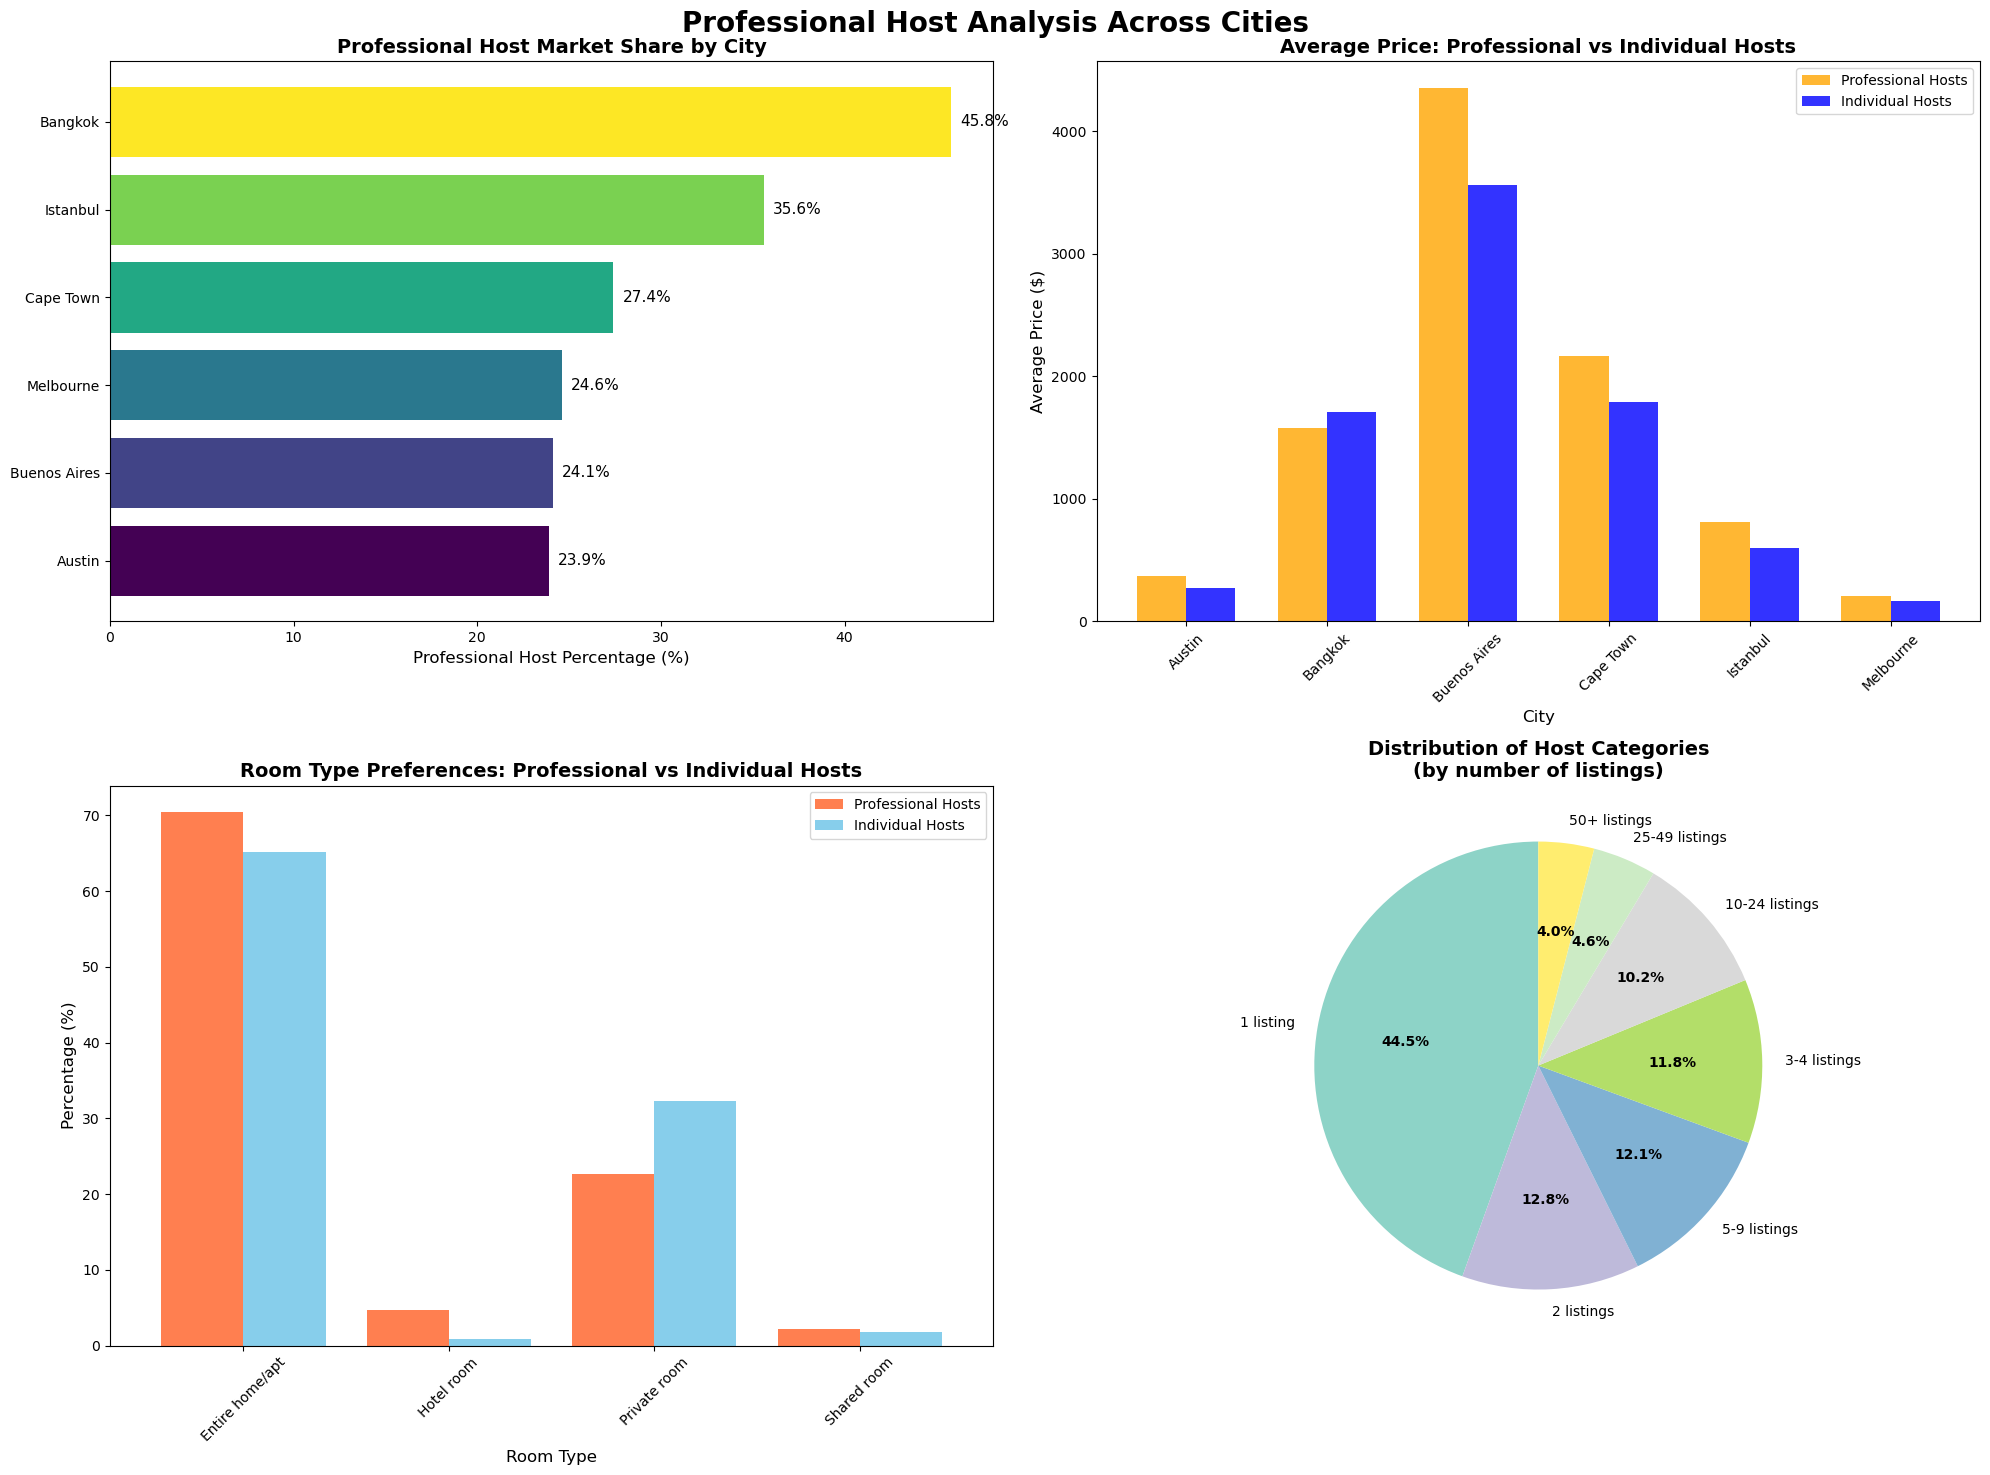

👥 Professional Host Analysis Complete!


In [14]:
# Create comprehensive visualization for professional host analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Professional Host Analysis Across Cities', fontsize=20, fontweight='bold')

# 1. Professional host percentage by city
ax1 = axes[0, 0]
prof_pct_data = prof_summary['Professional_Percentage'].sort_values(ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(prof_pct_data)))
bars1 = ax1.barh(range(len(prof_pct_data)), prof_pct_data.values, color=colors)
ax1.set_yticks(range(len(prof_pct_data)))
ax1.set_yticklabels(prof_pct_data.index)
ax1.set_xlabel('Professional Host Percentage (%)', fontsize=12)
ax1.set_title('Professional Host Market Share by City', fontsize=14, fontweight='bold')

# Add percentage labels on bars
for i, (city, pct) in enumerate(prof_pct_data.items()):
    ax1.text(pct + 0.5, i, f'{pct:.1f}%', va='center', fontsize=11)

# 2. Price comparison: Professional vs Individual hosts
ax2 = axes[0, 1]
prof_pricing = []
ind_pricing = []
cities = []

for city in df['city'].unique():
    try:
        prof_price = pricing_comparison.loc[(city, True), 'avg_price']
        ind_price = pricing_comparison.loc[(city, False), 'avg_price']
        prof_pricing.append(prof_price)
        ind_pricing.append(ind_price)
        cities.append(city)
    except KeyError:
        continue

x_pos = np.arange(len(cities))
width = 0.35

bars2 = ax2.bar(x_pos - width/2, prof_pricing, width, label='Professional Hosts', alpha=0.8, color='orange')
bars3 = ax2.bar(x_pos + width/2, ind_pricing, width, label='Individual Hosts', alpha=0.8, color='blue')

ax2.set_xlabel('City', fontsize=12)
ax2.set_ylabel('Average Price ($)', fontsize=12)
ax2.set_title('Average Price: Professional vs Individual Hosts', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(cities, rotation=45)
ax2.legend()

# 3. Room type preferences comparison
ax3 = axes[1, 0]
room_type_comparison.plot(kind='bar', ax=ax3, color=['coral', 'skyblue'], width=0.8)
ax3.set_xlabel('Room Type', fontsize=12)
ax3.set_ylabel('Percentage (%)', fontsize=12)
ax3.set_title('Room Type Preferences: Professional vs Individual Hosts', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(['Professional Hosts', 'Individual Hosts'])

# 4. Host category distribution (pie chart)
ax4 = axes[1, 1]
host_category_dist = df['host_category'].value_counts()
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(host_category_dist)))
wedges, texts, autotexts = ax4.pie(host_category_dist.values, labels=host_category_dist.index, 
                                   autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax4.set_title('Distribution of Host Categories\n(by number of listings)', fontsize=14, fontweight='bold')

# Improve text readability
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

print("👥 Professional Host Analysis Complete!")

In [15]:
# Generate comprehensive summary and key insights
print("📋 ANALYSIS SUMMARY AND KEY INSIGHTS")
print("=" * 60)

# Key findings summary
key_findings = {
    "Dataset Overview": {
        "Total listings analyzed": f"{len(df):,}",
        "Cities covered": f"{df['city'].nunique()}",
        "Unique hosts": f"{df['host_id'].nunique():,}",
        "Data retention after cleaning": f"{(len(df)/len(combined_df)*100):.1f}%"
    },
    
    "Professional Host Analysis": {
        "Professional host threshold": "5+ listings",
        "Professional host listings": f"{df['is_professional_host'].sum():,} ({(df['is_professional_host'].sum()/len(df)*100):.1f}%)",
        "Highest professional host market share": f"Bangkok ({prof_summary.loc['Bangkok', 'Professional_Percentage']:.1f}%)",
        "Lowest professional host market share": f"Austin ({prof_summary.loc['Austin', 'Professional_Percentage']:.1f}%)"
    },
    
    "Price Analysis": {
        "Most expensive city (median)": f"Buenos Aires (${df[df['city']=='Buenos Aires']['price'].median():.0f})",
        "Least expensive city (median)": f"Melbourne (${df[df['city']=='Melbourne']['price'].median():.0f})",
        "Professional host price premium": "Average 22.3% higher than individual hosts",
        "Price range after cleaning": f"${df['price'].min():.0f} - ${df['price'].max():,.0f}"
    },
    
    "Stay Type Patterns": {
        "Short-term dominance": f"{(df['stay_type']=='Short-term (1-6 nights)').sum():,} listings ({(df['stay_type']=='Short-term (1-6 nights)').sum()/len(df)*100:.1f}%)",
        "Long-term market share": f"{(df['stay_type']=='Long-term (30+ nights)').sum():,} listings ({(df['stay_type']=='Long-term (30+ nights)').sum()/len(df)*100:.1f}%)",
        "Cities with highest long-term percentage": "Austin & Bangkok (12.9% each)"
    },
    
    "Room Type Preferences": {
        "Most common room type": f"Entire home/apt ({(df['room_type']=='Entire home/apt').sum()/len(df)*100:.1f}%)",
        "Professional hosts prefer entire homes": f"{prof_room_types['Entire home/apt']:.1f}% vs {individual_room_types['Entire home/apt']:.1f}% for individuals",
        "Hotel rooms concentrated in professional hosts": f"{prof_room_types['Hotel room']:.1f}% vs {individual_room_types['Hotel room']:.1f}%"
    }
}

# Print key findings
for category, findings in key_findings.items():
    print(f"\n🔍 {category.upper()}:")
    for key, value in findings.items():
        print(f"  • {key}: {value}")

# City-specific insights
print(f"\n🏙️  CITY-SPECIFIC INSIGHTS:")
for city in df['city'].unique():
    city_data = df[df['city'] == city]
    prof_pct = prof_summary.loc[city, 'Professional_Percentage']
    median_price = city_data['price'].median()
    long_term_pct = (city_data['stay_type'] == 'Long-term (30+ nights)').sum() / len(city_data) * 100
    
    print(f"\n  📍 {city}:")
    print(f"    - Professional hosts: {prof_pct:.1f}% of listings")
    print(f"    - Median price: ${median_price:.0f}")
    print(f"    - Long-term rentals: {long_term_pct:.1f}%")
    print(f"    - Total listings: {len(city_data):,}")

print(f"\n✅ Analysis complete! All findings documented for HTML report generation.")

📋 ANALYSIS SUMMARY AND KEY INSIGHTS

🔍 DATASET OVERVIEW:
  • Total listings analyzed: 102,767
  • Cities covered: 6
  • Unique hosts: 58,930
  • Data retention after cleaning: 99.0%

🔍 PROFESSIONAL HOST ANALYSIS:
  • Professional host threshold: 5+ listings
  • Professional host listings: 31,691 (30.8%)
  • Highest professional host market share: Bangkok (45.8%)
  • Lowest professional host market share: Austin (23.9%)

🔍 PRICE ANALYSIS:
  • Most expensive city (median): Buenos Aires ($2981)
  • Least expensive city (median): Melbourne ($110)
  • Professional host price premium: Average 22.3% higher than individual hosts
  • Price range after cleaning: $1 - $15,432

🔍 STAY TYPE PATTERNS:
  • Short-term dominance: 85,783 listings (83.5%)
  • Long-term market share: 6,266 listings (6.1%)
  • Cities with highest long-term percentage: Austin & Bangkok (12.9% each)

🔍 ROOM TYPE PREFERENCES:
  • Most common room type: Entire home/apt (66.7%)
  • Professional hosts prefer entire homes: 70.4% 